In [4]:
#@title Runtime
use_tpu = False #@param

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
# import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
np.random.seed(0)

In [7]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
# labels = np.concatenate(
#     (
#         np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
#         np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
#     ),
#     axis=0,
# )
# weights = np.concatenate(
#     (np.ones((pos_data.shape[0]), dtype=pos_data.dtype), 
#      weights)
# )
# features = np.concatenate((pos_data, neg_data), axis=0)
# pos_data_lengths = np.count_nonzero(pos_data, axis=1)
# neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [4]:
# max_length = pos_data.shape[1]
# def encoder(seq, max_length=200):
#     alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
#     vec = np.zeros(max_length)
#     for i,l in enumerate(seq):
#         vec[i] = alphabet.index(l) + 1
#     return vec
# # sample unlabeled data
# def sample_permutations_from_vec(data_lengths, labeled_unlabeled_ratio=0.2, max_sequence_length=200):
#     alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
#     with open("../pdb_dist.txt", 'r') as f:
#         # the probabilities in this file are sorted based on the alphabet list above
#         pdb_dist = f.read().split()
#         pdb_dist = [float(item) for item in pdb_dist]
# #     unlabeled_seq_lengths = vec_pep_length(positive_data, ohe_vec=False)
# #     print(unlabeled_seq_lengths)
#     sampled_lengths = []
#     for length in data_lengths:
#         length_sample_batch = np.ones(int(1/labeled_unlabeled_ratio), dtype=int) * length
#         sampled_lengths.append(length_sample_batch)
#     sampled_lengths = np.array(sampled_lengths).flatten()
#     sampled_sequences = []
#     sampled_vecs = []
#     for length in tqdm(sampled_lengths):
# #         print(length)
#     #         random_alphabet_index = np.random.randint(len(alphabet), size=length)
#         # sample alphabet index based on weighted amino acid frequencies in pdb
#         random_alphabet_index = np.random.choice(len(alphabet), size=length, p=pdb_dist)
#         for _ in range(length):
#             pep = ''.join([alphabet[m] for m in random_alphabet_index])
#         vec_pep = encoder(pep, max_length=max_length)
#         # pad zeros
#     #     print(ohe_pep.shape)
# #         ohe_pep = np.concatenate([ohe_pep, np.zeros((max_sequence_length-ohe_pep.shape[0],20))],axis=0)
#         sampled_vecs.append(vec_pep)
#         sampled_sequences.append(pep)
# #     sampled_vecs = np.array(sampled_vecs)
#     return sampled_sequences, sampled_vecs
# # ohe_sequence_list = np.concatenate([ohe_sequence_list, np.zeros((190,10))],axis=1)
# pos_data_lengths = np.count_nonzero(pos_data, axis=1) + 1
# neg_data_lengths = np.count_nonzero(neg_data, axis=1) + 1
# labeled_unlabeled_ratio = 0.2
# sampled_sequences, sampled_vecs = sample_permutations_from_vec(pos_data_lengths,
#                                                                labeled_unlabeled_ratio=0.2, max_sequence_length=max_length)
# sampled_vecs = np.array(sampled_vecs)
# # X_unlabeled = sampled_vecs
# unlabeled_data_lengths = []
# for seq in sampled_sequences:
#     unlabeled_data_lengths.append(len(seq))

100%|██████████| 9130/9130 [00:00<00:00, 9809.93it/s]


In [8]:
def build_fakes(n, data):
    result = []
    for _ in range(n):
        # sample this many subsequences
        k = np.clip(np.random.poisson(1), 0, len(data) - 2) + 2
        idx = np.random.choice(range(len(data)), replace=False, size=k)                        
        seq = []
        lengths = []
        # cut-up k into one new sequence
        for i in range(k):
            if np.argmin(data[idx[i]]) > 1:
                lengths.append(np.ceil(2 * np.random.randint(1, np.argmin(data[idx[i]])) / k).astype(int))
                j = np.random.randint(0, np.argmin(data[idx[i]]) - lengths[i])
            else:
                lengths.append(1)
                j = 0
            seq.append(data[idx[i]][j:j+lengths[i]])
        # pad out    
        seq.append([0] * (len(data[0]) - sum(lengths)))
        # print(seq)
        result.append(np.concatenate(seq))
        # print(result)
        # break
    return np.array(result)
sampled_vecs = build_fakes(9130*5, pos_data)

In [10]:
X_positive = pos_data
X_negative = neg_data
X_unlabeled = sampled_vecs
print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Sampled unlabeled data:', len(sampled_vecs))

Positive data: 1826
Negative data: 7490
Sampled unlabeled data: 45650


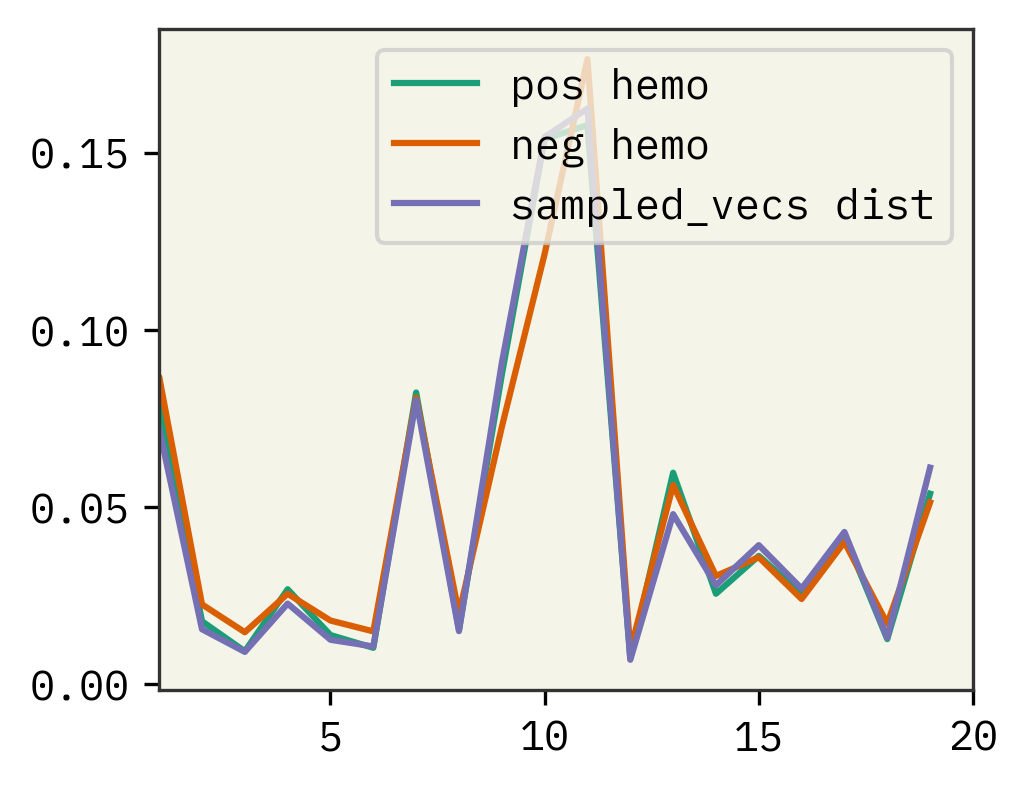

In [11]:

hist, bins = np.histogram(pos_data, bins=21)
counts_aa = hist[1:]
p_positive = counts_aa/np.sum(counts_aa)

hist, bins = np.histogram(neg_data, bins=21)
counts_aa = hist[1:]
p_negative = counts_aa/np.sum(counts_aa)

hist, bins = np.histogram(sampled_vecs, bins=21)
counts_aa = hist[1:]
p_unlabeled = counts_aa/np.sum(counts_aa)
plt.figure(dpi=300)
plt.plot(p_positive, label='pos hemo')
plt.plot(p_negative, label='neg hemo')
plt.plot(p_unlabeled, label='sampled_vecs dist')
plt.xlim([1,20])
plt.legend()

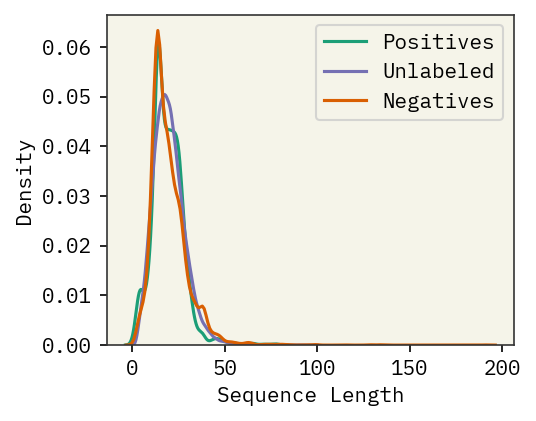

In [14]:
pos_data_lengths = np.count_nonzero(pos_data, axis=1) + 1
neg_data_lengths = np.count_nonzero(neg_data, axis=1) + 1
unlabeled_data_lengths = np.count_nonzero(sampled_vecs, axis=1) + 1
fig, ax = plt.subplots(dpi=150)
sns.kdeplot(pos_data_lengths, ax=ax, label='Positives', color='C0')
ax.set_xlabel('Sequence Length')
# ax.set_title(f'{peptide_label}')
sns.kdeplot(unlabeled_data_lengths, ax=ax, label='Unlabeled', color='C2')
sns.kdeplot(neg_data_lengths, ax=ax, label='Negatives', color='C1')
plt.legend()

In [17]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector):
    if index == 0:
      break
    seq.append(alphabet[int(index)-1])
  seq = ''.join(seq)
  return seq
# need to decode postive and negative data to get UniRep representations
pos_sequences = []
for f in pos_data:
  pos_sequences.append(decoder(f))

neg_sequences = []
for f in neg_data:
  neg_sequences.append(decoder(f))

sampled_sequences = []
for i, f in enumerate(sampled_vecs):
    sampled_sequences.append(decoder(f))

In [18]:
# Generating UniRep representations for postives, negatives and unlableled (This cell takes long to run)
from jax_unirep import get_reps
h_avg, h_final, c_final = get_reps(pos_sequences)
pos_UniRep = h_avg

h_avg, h_final, c_final = get_reps(neg_sequences)
neg_UniRep = h_avg

h_avg, h_final, c_final = get_reps(sampled_sequences)
unlabeled_UniRep = h_avg

In [9]:
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.model_selection import KFold
# from sklearn.metrics import f1_score
# from sklearn.metrics import recall_score
# kf = KFold(n_splits=5, random_state=None, shuffle=True)
# f1_scores = []
# recall_scores = []
# i = 0

# for train_index, test_index in kf.split(pos_UniRep):
#     X_train_positive_lof, X_test_positive_lof = pos_UniRep[train_index], pos_UniRep[test_index]
# #     s_train_positive_svm = np.ones(X_train_positive_svm.shape[0])
# #     s_test_positive_svm = y[train_index], y[test_index]
#     s_test_lof = np.ones(X_test_positive_lof.shape[0])
#     lof = LocalOutlierFactor(n_neighbors=64, algorithm='auto',
#                              metric='cosine', contamination=0.01,
#                              novelty=True, n_jobs=20, leaf_size=40)
#     lof.fit(X_train_positive_lof)
# #     X_validation_svm = np.concatenate([X_positive_test, X_unlabeled_test])

#     # Make prediction
#     s_pred = lof.predict(X_test_positive_lof)
#     f1 = f1_score(s_test_lof, s_pred, average='macro')
#     r = recall_score(s_test_lof, s_pred, average='macro')
#     print(f'Fold {i+1} - recall : {r:.3f}, f1 score : {f1:.3f}')
#     f1_scores.append(f1)
#     recall_scores.append(r)
#     i += 1
# #     break
# # lof_f1_score
# lof_f1_score = np.mean(f1_scores)
# lof_recall_score = np.mean(recall_scores)
# print(f'\nMean 5-Fold\n f1 score = {lof_f1_score:.3f}\n recall = {lof_recall_score:.3f}')

In [19]:
# Shuffling data
shuffled_indices = np.random.permutation(len(pos_data))
X_positive = pos_data[shuffled_indices]
shuffled_indices = np.random.permutation(len(neg_data))
X_negative = neg_data[shuffled_indices]
# shuffled_indices = np.random.permutation(len(sampled_vecs))
# X_unlabeled = sampled_vecs[shuffled_indices]

In [38]:
# OneClassSVM
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=True)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
f1_scores = []
recall_scores = []
i = 0
for train_index, test_index in kf.split(X_positive): # 
    X_train_positive_svm, X_test_positive_svm = X_positive[train_index], X_positive[test_index]
#     X_train_unlabeled_svm, X_test_unlabeled_svm = X_unlabeled[train_index], X_unlabeled[test_index]
#     X_validation_svm = np.concatenate([X_test_positive_svm, X_negative])
#     s_validation_svm = np.concatenate([np.ones(X_test_positive_svm.shape[0]), np.ones(X_negative.shape[0])*(-1)])
    s_test_svm = np.ones(X_test_positive_svm.shape[0])
#     s_train_positive_svm = np.ones(X_train_positive_svm.shape[0])
#     s_test_positive_svm = y[train_index], y[test_index]
#     neigh = KNeighborsClassifier(n_neighbors=1, metric='cosine', algorithm='auto', leaf_size=50)
#     neigh.fit(X_train_positive_svm_pca, np.ones(X_train_positive_svm_pca.shape[0]))
    one_class_svm = OneClassSVM(kernel='rbf', degree=3, gamma=0.001, nu=0.01, tol=1e-5) #  max_iter=50
    one_class_svm.fit(X_train_positive_svm)
    
#     X_validation_svm = np.concatenate([X_positive_test, X_unlabeled_test])

    # Make prediction
#     s_pred = neigh.predict(X_validation_svm)
    s_pred = one_class_svm.predict(X_test_positive_svm)
    f1 = f1_score(s_test_svm, s_pred, average='binary')
    r = recall_score(s_test_svm, s_pred, average='binary')
    print(f'Fold {i+1} - recall : {r:.3f}, f1 score : {f1:.3f}')
#     print(f'Fold {i+1} - f1 score : {f1:.3f}')
    f1_scores.append(f1)
    recall_scores.append(r)
    i += 1
#     break
svm_f1_score = np.mean(f1_scores)
svm_recall_score = np.mean(recall_scores)
print(f'\nMean 5-Fold\n f1 score = {svm_f1_score:.3f}\n recall = {svm_recall_score:.3f}')

Fold 1 - recall : 0.945, f1 score : 0.972
Fold 2 - recall : 0.904, f1 score : 0.950
Fold 3 - recall : 0.918, f1 score : 0.957
Fold 4 - recall : 0.945, f1 score : 0.972
Fold 5 - recall : 0.918, f1 score : 0.957

Mean 5-Fold
 f1 score = 0.962
 recall = 0.926


In [39]:
s_pred = one_class_svm.predict(X_unlabeled)
outlier_index = np.where(s_pred==-1)
initial_RNs = X_unlabeled[outlier_index]
print(initial_RNs.shape[0])

6671


In [40]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(X_positive), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

In [41]:
from sklearn.model_selection import train_test_split
X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(X_positive, np.ones(X_positive.shape[0]),
                                                                                        test_size=0.2, random_state=42)

In [50]:
RNs = initial_RNs
if RNs.shape[0] > X_train_positive.shape[0]:
    print ('Initial RN size already exceeds the positive size.')
else:
    down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
    X_train_with_RN = np.concatenate([X_train_positive, RNs])
    counts_X_train_with_RN= np.array([counts_aa(xi) for xi in X_train_with_RN])
    y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
    shuffler = np.random.permutation(len(X_train_with_RN))
    X_train_with_RN = X_train_with_RN[shuffler]
    # counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
    y_train_with_RN = y_train_with_RN[shuffler]
    X_test = np.concatenate([X_test_positive, X_negative])
    y_test = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_negative.shape[0])])
    # removing intial RN seeds from unlabeled
    RU = np.delete(X_unlabeled, outlier_index[0],axis=0)
    # RU = X_unlabeled
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9,
                                                            patience=5, min_lr=1e-7)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, min_delta=1e-2, restore_best_weights=True)
    L = None
    decay_epochs = 50
    N = len(X_train_with_RN)
    decay_steps = N  // config.batch_size * decay_epochs
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
    for i in tqdm(range(50)):
        tf.keras.backend.clear_session()
        model = build_model(L)
        model.compile(
                optimizer=tf.optimizers.Adam(1e-3),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)],
                )
        history = model.fit(
            [X_train_with_RN, np.array([counts_aa(xi) for xi in X_train_with_RN])] , y_train_with_RN,
            validation_data=([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test), 
            epochs=50,
            batch_size=16,
        #     batch_size=64,
        #     steps_per_epoch=100,
            # early_stopping
            callbacks=[reduce_lr, early_stopping],
            verbose=1,
        #         class_weight=class_weights
        )
        prob = model.predict([RU, np.array([counts_aa(xi) for xi in RU])])
        V = RU[np.argsort(prob[:,0])] 
    #     break
    #     print(f'Negatives found: {V.shape[0]}')
    #     if V.shape[0] == 0:
    #         print('All unlabeled were predicted as positive')
    #         RNs = outlier_values
    #         break
        # print(V.shape)
    #     else:
            # print(RNs.shape)
    #         n_downsample = V.shape[0] - X_train_positive_svm.shape[0]
    #         print(RNs.shape) 
    #     if i == 0:
    #         RNs = np.empty(shape=(0, 200))

        RNs = np.concatenate([RNs, V[:40*(i+1)]])
    #     RNs = V[:120*(i+1)]
    #         RU = RU[:][np.squeeze(prob > 0.001)]
        RU = np.delete(RU, np.argsort(prob[:,0])[:40*(i+1)], axis=0)
        print(f'Reliable negative size: {RNs.shape[0]}   Unlabeled size: {RU.shape[0]}')
        if RU.shape[0] == 0:
            print('All unlabeled were predicted as negative')
            break
        if RNs.shape[0] > X_train_positive.shape[0]:
            print('RNs size exceeded positives size')
            break
    #         RNs = equalizer(X_train_positive_lof, RNs)
        down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
        print(f'pos size: {down_sampled_X_train.shape[0]} RN size: {RNs.shape[0]}')
        X_train_with_RN = np.concatenate([X_train_positive, RNs])
        counts_X_train_with_RN = np.array([counts_aa(xi) for xi in X_train_with_RN])
        y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
        shuffler = np.random.permutation(len(X_train_with_RN))
        X_train_with_RN = X_train_with_RN[shuffler]
        counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
        y_train_with_RN = y_train_with_RN[shuffler]

Initial RN size already exceeds the positive size.


Now train with found RNs and positives. We do testing and validation based on the known negative data and a small subset of unobserved postives

In [53]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(RNs.shape[0], dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, RNs), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)
# add true known negatives to validation and test data
split = X_negative.shape[0]//5 *4
X_negative_val, X_negative_test = X_negative[:split], X_negative[split:]
X_val = np.append(X_val, X_negative_val, axis=0)
y_val = np.append(y_val, np.zeros(X_negative_val.shape[0]), axis=0)
X_test = np.append(X_test, X_negative_test, axis=0)
y_test = np.append(y_test, np.zeros(X_negative_test.shape[0]), axis=0)
shuffler = np.random.permutation(len(X_val))
X_val = X_val[shuffler]
y_val = y_val[shuffler]
shuffler = np.random.permutation(len(X_test))
X_test = X_test[shuffler]
y_test = y_test[shuffler]


In [54]:
tf.keras.backend.clear_session()
model = build_model(L)
#   L = 190
#   model = build_CNN_model(L, reg=0, add_dropout=True)
decay_epochs = 50
N = len(features)
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
  config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn, clipnorm=1.0)
model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [55]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=10)],
    epochs=150, batch_size=16)

lr = 0.001
Epoch 1/150
478/478 [==============================] - 24s 31ms/step - loss: 0.2522 - auc: 0.8978 - binary_accuracy: 0.9180 - val_loss: 2.3017 - val_auc: 0.5992 - val_binary_accuracy: 0.3251
lr = 0.0009992013
Epoch 2/150
478/478 [==============================] - 12s 26ms/step - loss: 0.1818 - auc: 0.9345 - binary_accuracy: 0.9473 - val_loss: 2.5629 - val_auc: 0.5646 - val_binary_accuracy: 0.3335
lr = 0.0009968076
Epoch 3/150
478/478 [==============================] - 12s 26ms/step - loss: 0.1593 - auc: 0.9465 - binary_accuracy: 0.9534 - val_loss: 3.2406 - val_auc: 0.5798 - val_binary_accuracy: 0.3146
lr = 0.0009928265
Epoch 4/150
478/478 [==============================] - 12s 25ms/step - loss: 0.1572 - auc: 0.9557 - binary_accuracy: 0.9507 - val_loss: 2.7751 - val_auc: 0.5834 - val_binary_accuracy: 0.3632
lr = 0.000987271
Epoch 5/150
478/478 [==============================] - 12s 24ms/step - loss: 0.1487 - auc: 0.9567 - binary_accuracy: 0.9558 - val_loss: 2.9009 - val_auc: 

53/53 [==============================] - 3s 8ms/step - loss: 4.2012 - auc: 0.6208 - binary_accuracy: 0.3106


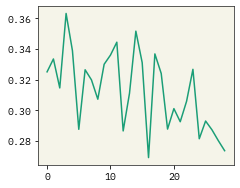

In [56]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()

In [57]:
# tuning threshold for accuracy
y_hat_test = model.predict([X_test, np.array([counts_aa(xi) for xi in X_test])])

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in y_hat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Adjusted Accuracy with new threshold: {acc:.3f}')

Best Threshold=6.797734, G-Mean=0.625
Adjusted Accuracy with new threshold: 0.624


Let's see how the model works with classical positive-negative classification

In [20]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(neg_data.shape[0], dtype=neg_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)

In [21]:
tf.keras.backend.clear_session()
model = build_model(L)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [22]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)

Epoch 1/150
lr = 0.001
262/262 [==============================] - 105s 371ms/step - loss: 0.4908 - auc: 0.6104 - binary_accuracy: 0.7978 - val_loss: 0.4474 - val_auc: 0.7447 - val_binary_accuracy: 0.8040
Epoch 2/150
lr = 0.0009984514
262/262 [==============================] - 96s 366ms/step - loss: 0.4570 - auc: 0.6979 - binary_accuracy: 0.8037 - val_loss: 0.4434 - val_auc: 0.7368 - val_binary_accuracy: 0.8027
Epoch 3/150
lr = 0.0009938151
262/262 [==============================] - 96s 366ms/step - loss: 0.4439 - auc: 0.7283 - binary_accuracy: 0.8031 - val_loss: 0.4286 - val_auc: 0.7667 - val_binary_accuracy: 0.8054
Epoch 4/150
lr = 0.0009861198
262/262 [==============================] - 96s 366ms/step - loss: 0.4333 - auc: 0.7489 - binary_accuracy: 0.8027 - val_loss: 0.4308 - val_auc: 0.7639 - val_binary_accuracy: 0.8081
Epoch 5/150
lr = 0.00097541336
262/262 [==============================] - 96s 368ms/step - loss: 0.4278 - auc: 0.7579 - binary_accuracy: 0.8038 - val_loss: 0.4191 - v

6/6 [==============================] - 1s 88ms/step - loss: 0.3855 - auc: 0.7702 - binary_accuracy: 0.8342


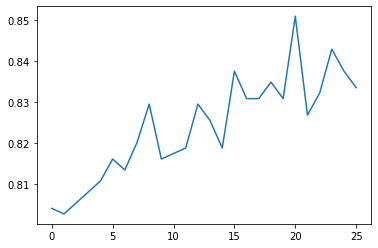

In [23]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()